<a href="https://colab.research.google.com/github/pyoph/nlp-lab-text-embedding/blob/main/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  NLP-lab :  Plongements de mots (word embeddings)

                                            Christopher Kermorvant

                            “The meaning of a word can be inferred by the company it keeps”

Dans cette série d'exercices, nous allons explorer  trois  plongements (embeddings) de mots :

*  [Collobert & Weston](http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf) https://ronan.collobert.com/senna/
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [BERT](https://huggingface.co/bert-base-uncased)

   
Pour les deux premiers, nous examinerons les mots les plus proches et visualiserons leurs positions dans l'espaces après réduction de dimension. Puis nous procéderons à des [évaluations](https://arxiv.org/pdf/1801.09536.pdf) qualitatives et intrinsèques des embeddings.

Enfin nous étudierons les raisonnements par analogies que l'on peut conduire par l'arithmétique sur les embeddings (et leurs biais).

Pour BERT, nous étudierons la représentation d'un mot polysémique en fonction de son contexte.

Dans le code déjà fourni, ajouter votre code à l'endroit indiqué par `YOUR CODE HERE`.


In [4]:
# basic imports
import os

# disable warnings for libraries
import warnings
warnings.filterwarnings("ignore")

# configure logger
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)


In [16]:
#!wget https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip
!unzip corgiredirector?site=https:%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip

Archive:  corgiredirector?site=https:%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of corgiredirector?site=https:%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip or
        corgiredirector?site=https:%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip.zip, and cannot find corgiredirector?site=https:%2F%2Fstorage.teklia.com%2Fshared%2Fdeepnlp-labs%2Fcollobert_embeddings.txt.zip.ZIP, period.

No zipfiles found.


## 1. Les fichiers d'embeddings pré-entraînés

Téléchargez dans `data` les fichiers contenant les embeddings :
* Collobert (taille 50) : [collobert_embeddings.txt.zip](https://storage.teklia.com/shared/deepnlp-labs/collobert_embeddings.txt.zip) qui contient les vecteurs d'embeddings  et [collobert_words.lst](https://storage.teklia.com/shared/deepnlp-labs/collobert_words.lst) qui contient les mots associés;
* Glove (taille 50):  [glove.6B.50d.txt.zip](https://storage.teklia.com/shared/deepnlp-labs/glove.6B.50d.txt.zip) 67 618 Kb qui contient à la fois les vecteurs et les mots.

Il faut décompresser les fichiers pour pouvoir les charger.

N'hésitez pas à ouvrir les fichiers pour voir ce qu'ils contiennent (c'est parfois surprennant).

#### Question :
>* Donner la taille des fichiers d'embeddings avant unzip
embeddings.txt.zip 23,7 Mo
(https://storage.teklia.com/shared/deepnlp-labs/glove.6B.50d.txt.zip) 67 618 Kb
>* En explorant le contenu des fichiers d'embedding, donner le nombre de mots pour lesquels ces fichiers fournissent des embeddings



## 2. Exploration des embeddings

### Liste des mots les plus proches

L'objectif de cet exercice est de lister les mots les plus proches d'un mot donné pour l'embeddings Collobert. Dans un premier temps, nous allons charger les vecteurs de l'embedding Collobert dans un array numpy et les mots associés dans une liste python. Ensuite, nous utiliserons la structure de données [KDTree de scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) pour faire une recherche rapide des vecteurs les plus proches d'une série de mots.

### Chargement des embeddings

#### Question :
>* charger les vecteurs d'embeddings à partir du fichier `data/collobert_embeddings.txt` en utilisant la fonction numpy [genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html)
>* charger dans une liste python les mots associés aux vecteurs à partir du fichier `data/collobert_words.lst` (avec `open()` et `readlines()`)
>* vérifiez que les tailles sont correctes



In [17]:
import numpy as np

fichier = 'collobert_embeddings.txt'

data = np.genfromtxt(fichier)



In [20]:
fichier_mots = 'collobert_words.lst'

# Ouvrir le fichier en mode lecture
with open(fichier_mots, 'r', encoding='utf-8') as fichier:
    # Lire toutes les lignes du fichier
    lignes = fichier.readlines()

# Supprimer les sauts de ligne et créer une liste de mots
mots = [ligne.strip() for ligne in lignes]
len(mots)
# Afficher la liste de mots
#print(mots)

130000

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Les arbres KD (KD tree) sont une structure de données très efficace pour stocker de grands ensemble de points dans une espace multi-dimensionnel et faire des recherches très efficaces de plus proches voisins.

#### Question
> * Initialisez la structure de [KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) avec les vecteurs d'embeddings de Collobert
> * En utilisant la fonction [tree.query](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query), afficher les 5 mots les plus proches des mots suivants : 'mother', 'computer', 'dentist', 'war', 'president', 'secretary', 'nurse'
     * *Indice : vous pouvez utiliser la fonction `collobert_words.index(w)` pour obtenir l'indice d'un mot dans la liste des mots*
> * Créer une liste `words_plus_neighbors` contenant les mots et tous leurs voisins (pour la question suivante)

In [52]:

# Charger les vecteurs d'embeddings à partir d'un fichier (remplacez le chemin par le vôtre)
embedding_file = 'collobert_embeddings.txt'

# Charger les vecteurs en tant que tableau numpy
embeddings = np.loadtxt(embedding_file)

# Initialiser la structure de KDTree avec les vecteurs d'embeddings
kdtree = spatial.KDTree(embeddings)

# Liste des mots associés aux vecteurs (à partir du fichier collobert_words.lst)
mots_file = 'collobert_words.lst'
with open(mots_file, 'r', encoding='utf-8') as file:
    mots = [line.strip() for line in file.readlines()]

# Mots à rechercher
mots_a_rechercher = ['mother', 'computer', 'dentist', 'war', 'president', 'secretary', 'nurse']
words_plus_neighbors = []

# Effectuer la recherche pour chaque mot
for mot in mots_a_rechercher:
    # Vérifier si le mot est dans la liste
    if mot in mots:
        # Trouver les indices des 5 mots les plus proches dans l'arbre KD
        indices_proches = kdtree.query(embeddings[mots.index(mot)], k=6)[1][1:]

        # Afficher les résultats
        mots_proches = [mots[indice] for indice in indices_proches]
        print(f"Les 5 mots les plus proches de '{mot}': {mots_proches}")
        neighbors = [mots[indice] for indice in indices_proches]

        words_plus_neighbors.append((mot, neighbors))

    else:
        # Gérer le cas où le mot n'est pas dans la liste
        print(f"Le mot '{mot}' n'est pas présent dans la liste des mots.")


# Afficher la liste words_plus_neighbors
for item in words_plus_neighbors:
    print(f"Mot: {item[0]}, Voisins: {item[1]}")


Les 5 mots les plus proches de 'mother': ['daughter', 'wife', 'father', 'husband', 'son']
Les 5 mots les plus proches de 'computer': ['laptop', 'multimedia', 'desktop', 'software', 'wiki']
Les 5 mots les plus proches de 'dentist': ['pharmacist', 'midwife', 'physician', 'housekeeper', 'veterinarian']
Les 5 mots les plus proches de 'war': ['revolution', 'death', 'court', 'independence', 'history']
Les 5 mots les plus proches de 'president': ['governor', 'chairman', 'mayor', 'secretary', 'senator']
Les 5 mots les plus proches de 'secretary': ['minister', 'treasurer', 'chairman', 'commissioner', 'undersecretary']
Les 5 mots les plus proches de 'nurse': ['physician', 'veterinarian', 'dentist', 'surgeon', 'midwife']
Mot: mother, Voisins: ['daughter', 'wife', 'father', 'husband', 'son']


TypeError: 'numpy.ndarray' object is not callable

In [66]:
"""
Downloading NeuroImaging datasets: utility functions
"""
import os
import numpy as np
import collections.abc
import contextlib
import fnmatch
import hashlib
import pickle
import shutil
import time
import sys
import tarfile
import urllib
import warnings
import zipfile
import json

import requests

#from .._utils import fill_doc

_REQUESTS_TIMEOUT = (15.1, 61)


def md5_hash(string):
    m = hashlib.md5()
    m.update(string.encode('utf-8'))
    return m.hexdigest()


def _format_time(t):
    if t > 60:
        return "%4.1fmin" % (t / 60.)
    else:
        return " %5.1fs" % (t)


def _md5_sum_file(path):
    """ Calculates the MD5 sum of a file.
    """
    with open(path, 'rb') as f:
        m = hashlib.md5()
        while True:
            data = f.read(8192)
            if not data:
                break
            m.update(data)
    return m.hexdigest()


def _read_md5_sum_file(path):
    """ Reads a MD5 checksum file and returns hashes as a dictionary.
    """
    with open(path, "r") as f:
        hashes = {}
        while True:
            line = f.readline()
            if not line:
                break
            h, name = line.rstrip().split('  ', 1)
            hashes[name] = h
    return hashes


def readlinkabs(link):
    """
    Return an absolute path for the destination
    of a symlink
    """
    path = os.readlink(link)
    if os.path.isabs(path):
        return path
    return os.path.join(os.path.dirname(link), path)


def _chunk_report_(bytes_so_far, total_size, initial_size, t0):
    """Show downloading percentage.

    Parameters
    ----------
    bytes_so_far : int
        Number of downloaded bytes.

    total_size : int
        Total size of the file (may be 0/None, depending on download method).

    t0 : int
        The time in seconds (as returned by time.time()) at which the
        download was resumed / started.

    initial_size : int
        If resuming, indicate the initial size of the file.
        If not resuming, set to zero.

    """
    if not total_size:
        sys.stderr.write("\rDownloaded %d of ? bytes." % (bytes_so_far))

    else:
        # Estimate remaining download time
        total_percent = float(bytes_so_far) / total_size

        current_download_size = bytes_so_far - initial_size
        bytes_remaining = total_size - bytes_so_far
        dt = time.time() - t0
        download_rate = current_download_size / max(1e-8, float(dt))
        # Minimum rate of 0.01 bytes/s, to avoid dividing by zero.
        time_remaining = bytes_remaining / max(0.01, download_rate)

        # Trailing whitespace is to erase extra char when message length
        # varies
        sys.stderr.write(
            "\rDownloaded %d of %d bytes (%.1f%%, %s remaining)"
            % (bytes_so_far, total_size, total_percent * 100,
               _format_time(time_remaining)))



def _chunk_read_(response, local_file, chunk_size=8192, report_hook=None,
                 initial_size=0, total_size=None, verbose=1):
    """Download a file chunk by chunk and show advancement

    Parameters
    ----------
    response : urllib.response.addinfourl
        Response to the download request in order to get file size.

    local_file : file
        Hard disk file where data should be written.

    chunk_size : int, optional
        Size of downloaded chunks. Default=8192.

    report_hook : bool, optional
        Whether or not to show downloading advancement. Default: None

    initial_size : int, optional
        If resuming, indicate the initial size of the file.
        Default=0.

    total_size : int, optional
        Expected final size of download (None means it is unknown).
    %(verbose)s

    Returns
    -------
    data : string
        The downloaded file.

    """
    try:
        if total_size is None:
            total_size = response.headers.get('Content-Length').strip()
        total_size = int(total_size) + initial_size
    except Exception as e:
        if verbose > 2:
            print("Warning: total size could not be determined.")
            if verbose > 3:
                print("Full stack trace: %s" % e)
        total_size = None
    bytes_so_far = initial_size

    t0 = time_last_display = time.time()
    for chunk in response.iter_content(chunk_size):
        bytes_so_far += len(chunk)
        time_last_read = time.time()
        if (report_hook and
                # Refresh report every second or when download is
                # finished.
                (time_last_read > time_last_display + 1. or not chunk)):
            _chunk_report_(bytes_so_far,
                           total_size, initial_size, t0)
            time_last_display = time_last_read
        if chunk:
            local_file.write(chunk)
        else:
            break


def get_data_dirs(data_dir=None):
    """Returns the directories in which nilearn looks for data.

    This is typically useful for the end-user to check where the data is
    downloaded and stored.

    Parameters
    ----------
    %(data_dir)s

    Returns
    -------
    paths : list of strings
        Paths of the dataset directories.

    Notes
    -----
    This function retrieves the datasets directories using the following
    priority :

    1. defaults system paths
    2. the keyword argument data_dir
    3. the global environment variable NILEARN_SHARED_DATA
    4. the user environment variable NILEARN_DATA
    5. nilearn_data in the user home folder

    """
    # We build an array of successive paths by priority
    # The boolean indicates if it is a pre_dir: in that case, we won't add the
    # dataset name to the path.
    paths = []

    # Check data_dir which force storage in a specific location
    if data_dir is not None:
        paths.extend(str(data_dir).split(os.pathsep))

    # If data_dir has not been specified, then we crawl default locations
    if data_dir is None:
        global_data = os.getenv('NILEARN_SHARED_DATA')
        if global_data is not None:
            paths.extend(global_data.split(os.pathsep))

        local_data = os.getenv('NILEARN_DATA')
        if local_data is not None:
            paths.extend(local_data.split(os.pathsep))

        paths.append(os.path.expanduser('~/nilearn_data'))
    return paths



def _get_dataset_dir(dataset_name, data_dir=None, default_paths=None,
                     verbose=1):
    """Creates if necessary and returns data directory of given dataset.

    Parameters
    ----------
    dataset_name : string
        The unique name of the dataset.
    %(data_dir)s
    default_paths : list of string, optional
        Default system paths in which the dataset may already have been
        installed by a third party software. They will be checked first.
    %(verbose)s

    Returns
    -------
    data_dir : string
        Path of the given dataset directory.

    Notes
    -----
    This function retrieves the datasets directory (or data directory) using
    the following priority :

    1. defaults system paths
    2. the keyword argument data_dir
    3. the global environment variable NILEARN_SHARED_DATA
    4. the user environment variable NILEARN_DATA
    5. nilearn_data in the user home folder

    """
    paths = []
    # Search possible data-specific system paths
    if default_paths is not None:
        for default_path in default_paths:
            paths.extend([
                (d, True)
                for d in str(default_path).split(os.pathsep)]
            )

    paths.extend([(d, False) for d in get_data_dirs(data_dir=data_dir)])

    if verbose > 2:
        print('Dataset search paths: %s' % paths)

    # Check if the dataset exists somewhere
    for path, is_pre_dir in paths:
        if not is_pre_dir:
            path = os.path.join(path, dataset_name)
        if os.path.islink(path):
            # Resolve path
            path = readlinkabs(path)
        if os.path.exists(path) and os.path.isdir(path):
            if verbose > 1:
                print('\nDataset found in %s\n' % path)
            return path

    # If not, create a folder in the first writeable directory
    errors = []
    for (path, is_pre_dir) in paths:
        if not is_pre_dir:
            path = os.path.join(path, dataset_name)
        if not os.path.exists(path):
            try:
                os.makedirs(path)
                if verbose > 0:
                    print('\nDataset created in %s\n' % path)
                return path
            except Exception as exc:
                short_error_message = getattr(exc, 'strerror', str(exc))
                errors.append('\n -{0} ({1})'.format(
                    path, short_error_message))

    raise OSError('Nilearn tried to store the dataset in the following '
                  'directories, but:' + ''.join(errors))


# The functions _is_within_directory and _safe_extract were implemented in
# https://github.com/nilearn/nilearn/pull/3391 to address a directory
# traversal vulnerability https://github.com/advisories/GHSA-gw9q-c7gh-j9vm
def _is_within_directory(directory, target):
    abs_directory = os.path.abspath(directory)
    abs_target = os.path.abspath(target)

    prefix = os.path.commonprefix([abs_directory, abs_target])

    return prefix == abs_directory


def _safe_extract(tar, path=".", members=None, *, numeric_owner=False):
    for member in tar.getmembers():
        member_path = os.path.join(path, member.name)
        if not _is_within_directory(path, member_path):
            raise Exception("Attempted Path Traversal in Tar File")

    tar.extractall(path, members, numeric_owner=numeric_owner)



def _uncompress_file(file_, delete_archive=True, verbose=1):
    """Uncompress files contained in a data_set.

    Parameters
    ----------
    file_ : string
        Path of file to be uncompressed.

    delete_archive : bool, optional
        Whether or not to delete archive once it is uncompressed.
        Default=True.
    %(verbose)s

    Notes
    -----
    This handles zip, tar, gzip and bzip files only.

    """
    if verbose > 0:
        sys.stderr.write('Extracting data from %s...' % file_)
    data_dir = os.path.dirname(file_)
    # We first try to see if it is a zip file
    try:
        filename, ext = os.path.splitext(file_)
        with open(file_, "rb") as fd:
            header = fd.read(4)
        processed = False
        if zipfile.is_zipfile(file_):
            z = zipfile.ZipFile(file_)
            z.extractall(path=data_dir)
            z.close()
            if delete_archive:
                os.remove(file_)
            file_ = filename
            processed = True
        elif ext == '.gz' or header.startswith(b'\x1f\x8b'):
            import gzip
            if ext == '.tgz':
                filename = filename + '.tar'
            elif ext == '':
                # We rely on the assumption that gzip files have an extension
                shutil.move(file_, file_ + '.gz')
                file_ = file_ + '.gz'
            with gzip.open(file_) as gz:
                with open(filename, 'wb') as out:
                    shutil.copyfileobj(gz, out, 8192)
            # If file is .tar.gz, this will be handled in the next case
            if delete_archive:
                os.remove(file_)
            file_ = filename
            processed = True
        if os.path.isfile(file_) and tarfile.is_tarfile(file_):
            with contextlib.closing(tarfile.open(file_, "r")) as tar:
                _safe_extract(tar, path=data_dir)
            if delete_archive:
                os.remove(file_)
            processed = True
        if not processed:
            raise IOError(
                    "[Uncompress] unknown archive file format: %s" % file_)

        if verbose > 0:
            sys.stderr.write('.. done.\n')
    except Exception as e:
        if verbose > 0:
            print('Error uncompressing file: %s' % e)
        raise


def _filter_column(array, col, criteria):
    """Return index array matching criteria

    Parameters
    ----------
    array : numpy array with columns
        Array in which data will be filtered.

    col : string
        Name of the column.

    criteria : integer (or float), pair of integers, string or list of these
        if integer, select elements in column matching integer
        if a tuple, select elements between the limits given by the tuple
        if a string, select elements that match the string

    """
    # Raise an error if the column does not exist. This is the only way to
    # test it across all possible types (pandas, recarray...)
    try:
        array[col]
    except:
        raise KeyError('Filtering criterion %s does not exist' % col)

    if (not isinstance(criteria, str) and
        not isinstance(criteria, bytes) and
        not isinstance(criteria, tuple) and
            isinstance(criteria, collections.abc.Iterable)):
        filter = np.zeros(array.shape[0], dtype=bool)
        for criterion in criteria:
            filter = np.logical_or(filter,
                                   _filter_column(array, col, criterion))
        return filter

    if isinstance(criteria, tuple):
        if len(criteria) != 2:
            raise ValueError("An interval must have 2 values")
        if criteria[0] is None:
            return array[col] <= criteria[1]
        if criteria[1] is None:
            return array[col] >= criteria[0]
        filter = array[col] <= criteria[1]
        return np.logical_and(filter, array[col] >= criteria[0])

    # Handle strings with different encodings
    if isinstance(criteria, (str, bytes)):
        criteria = np.array(criteria).astype(array[col].dtype)

    return array[col] == criteria


def _filter_columns(array, filters, combination='and'):
    """Return indices of recarray entries that match criteria.

    Parameters
    ----------
    array : numpy array with columns
        Array in which data will be filtered.

    filters : list of criteria
        See _filter_column.

    combination : string {'and', 'or'}, optional
        String describing the combination operator. Possible values are "and"
        and "or". Default='and'.

    """
    if combination == 'and':
        fcomb = np.logical_and
        mask = np.ones(array.shape[0], dtype=bool)
    elif combination == 'or':
        fcomb = np.logical_or
        mask = np.zeros(array.shape[0], dtype=bool)
    else:
        raise ValueError('Combination mode not known: %s' % combination)

    for column in filters:
        mask = fcomb(mask, _filter_column(array, column, filters[column]))
    return mask


class _NaiveFTPAdapter(requests.adapters.BaseAdapter):
    def send(self, request, timeout=None, **kwargs):
        try:
            timeout, _ = timeout
        except Exception:
            pass
        try:
            data = urllib.request.urlopen(request.url, timeout=timeout)
        except Exception as e:
            raise requests.RequestException(e.reason)
        data.release_conn = data.close
        resp = requests.Response()
        resp.url = data.geturl()
        resp.status_code = data.getcode() or 200
        resp.raw = data
        resp.headers = dict(data.info().items())
        return resp

    def close(self):
        pass



def _fetch_file(url, data_dir, resume=True, overwrite=False,
                md5sum=None, username=None, password=None,
                verbose=1, session=None):
    """Load requested file, downloading it if needed or requested.

    Parameters
    ----------
    %(url)s
    %(data_dir)s
    %(resume)s
    overwrite : bool, optional
        If true and file already exists, delete it. Default=False.

    md5sum : string, optional
        MD5 sum of the file. Checked if download of the file is required.

    username : string, optional
        Username used for basic HTTP authentication.

    password : string, optional
        Password used for basic HTTP authentication.
    %(verbose)s
    session : requests.Session, optional
        Session to use to send requests.

    Returns
    -------
    files : string
        Absolute path of downloaded file.

    Notes
    -----
    If, for any reason, the download procedure fails, all downloaded files are
    removed.

    """
    if session is None:
        with requests.Session() as session:
            session.mount("ftp:", _NaiveFTPAdapter())
            return _fetch_file(
                url, data_dir, resume=resume, overwrite=overwrite,
                md5sum=md5sum, username=username, password=password,
                verbose=verbose, session=session)
    # Determine data path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Determine filename using URL
    parse = urllib.parse.urlparse(url)
    file_name = os.path.basename(parse.path)
    if file_name == '':
        file_name = md5_hash(parse.path)

    temp_file_name = file_name + ".part"
    full_name = os.path.join(data_dir, file_name)
    temp_full_name = os.path.join(data_dir, temp_file_name)
    if os.path.exists(full_name):
        if overwrite:
            os.remove(full_name)
        else:
            return full_name
    if os.path.exists(temp_full_name):
        if overwrite:
            os.remove(temp_full_name)
    t0 = time.time()
    local_file = None
    initial_size = 0

    try:
        # Download data
        headers = {}
        auth = None
        if username is not None and password is not None:
            if not url.startswith('https'):
                raise ValueError(
                    'Authentication was requested on a non  secured URL (%s).'
                    'Request has been blocked for security reasons.' % url)
            auth = (username, password)
        if verbose > 0:
            displayed_url = url.split('?')[0] if verbose == 1 else url
            print('Downloading data from %s ...' % displayed_url)
        if resume and os.path.exists(temp_full_name):
            # Download has been interrupted, we try to resume it.
            local_file_size = os.path.getsize(temp_full_name)
            # If the file exists, then only download the remainder
            headers["Range"] = "bytes={}-".format(local_file_size)
            try:
                req = requests.Request(
                    method="GET", url=url, headers=headers, auth=auth)
                prepped = session.prepare_request(req)
                with session.send(prepped, stream=True,
                                  timeout=_REQUESTS_TIMEOUT) as resp:
                    resp.raise_for_status()
                    content_range = resp.headers.get('Content-Range')
                    if (content_range is None or not content_range.startswith(
                            'bytes {}-'.format(local_file_size))):
                        raise IOError('Server does not support resuming')
                    initial_size = local_file_size
                    with open(local_file, "ab") as fh:
                        _chunk_read_(
                            resp, fh, report_hook=(verbose > 0),
                            initial_size=initial_size, verbose=verbose)
            except Exception:
                if verbose > 0:
                    print('Resuming failed, try to download the whole file.')
                return _fetch_file(
                    url, data_dir, resume=False, overwrite=overwrite,
                    md5sum=md5sum, username=username, password=password,
                    verbose=verbose, session=session)
        else:
            req = requests.Request(
                method="GET", url=url, headers=headers, auth=auth)
            prepped = session.prepare_request(req)
            with session.send(
                    prepped, stream=True, timeout=_REQUESTS_TIMEOUT) as resp:
                resp.raise_for_status()
                with open(temp_full_name, "wb") as fh:
                    _chunk_read_(resp, fh, report_hook=(verbose > 0),
                                 initial_size=initial_size, verbose=verbose)
        shutil.move(temp_full_name, full_name)
        dt = time.time() - t0
        if verbose > 0:
            # Complete the reporting hook
            sys.stderr.write(' ...done. ({0:.0f} seconds, {1:.0f} min)\n'
                             .format(dt, dt // 60))
    except (requests.RequestException):
        sys.stderr.write("Error while fetching file %s; dataset "
                         "fetching aborted." % (file_name))
        raise
    if md5sum is not None:
        if (_md5_sum_file(full_name) != md5sum):
            raise ValueError("File %s checksum verification has failed."
                             " Dataset fetching aborted." % local_file)
    return full_name


def _get_dataset_descr(ds_name):
    module_path = os.path.dirname(os.path.abspath(__file__))

    fname = ds_name

    try:
        with open(os.path.join(module_path, 'description', fname + '.rst'),
                  'rb') as rst_file:
            descr = rst_file.read()
    except IOError:
        descr = ''

    if descr == '':
        warnings.warn("Could not find dataset description.")

    if isinstance(descr, bytes):
        descr = descr.decode('utf-8')

    return descr


def movetree(src, dst):
    """Move an entire tree to another directory. Any existing file is
    overwritten"""
    names = os.listdir(src)

    # Create destination dir if it does not exist
    if not os.path.exists(dst):
        os.makedirs(dst)
    errors = []

    for name in names:
        srcname = os.path.join(src, name)
        dstname = os.path.join(dst, name)
        try:
            if os.path.isdir(srcname) and os.path.isdir(dstname):
                movetree(srcname, dstname)
                os.rmdir(srcname)
            else:
                shutil.move(srcname, dstname)
        except (IOError, os.error) as why:
            errors.append((srcname, dstname, str(why)))
        # catch the Error from the recursive movetree so that we can
        # continue with other files
        except Exception as err:
            errors.extend(err.args[0])
    if errors:
        raise Exception(errors)



def _fetch_files(data_dir, files, resume=True, verbose=1, session=None):
    """Load requested dataset, downloading it if needed or requested.

    This function retrieves files from the hard drive or download them from
    the given urls. Note to developers: All the files will be first
    downloaded in a sandbox and, if everything goes well, they will be moved
    into the folder of the dataset. This prevents corrupting previously
    downloaded data. In case of a big dataset, do not hesitate to make several
    calls if needed.

    Parameters
    ----------
    %(data_dir)s
    files : list of (string, string, dict)
        List of files and their corresponding url with dictionary that contains
        options regarding the files. Eg. (file_path, url, opt). If a file_path
        is not found in data_dir, as in data_dir/file_path the download will
        be immediately cancelled and any downloaded files will be deleted.
        Options supported are:
            * 'move' if renaming the file or moving it to a subfolder is needed
            * 'uncompress' to indicate that the file is an archive
            * 'md5sum' to check the md5 sum of the file
            * 'overwrite' if the file should be re-downloaded even if it exists
    %(resume)s
    %(verbose)s
    session : `requests.Session`, optional
        Session to use to send requests.

    Returns
    -------
    files : list of string
        Absolute paths of downloaded files on disk.

    """
    if session is None:
        with requests.Session() as session:
            session.mount("ftp:", _NaiveFTPAdapter())
            return _fetch_files(
                data_dir, files, resume=resume,
                verbose=verbose, session=session)
    # There are two working directories here:
    # - data_dir is the destination directory of the dataset
    # - temp_dir is a temporary directory dedicated to this fetching call. All
    #   files that must be downloaded will be in this directory. If a corrupted
    #   file is found, or a file is missing, this working directory will be
    #   deleted.
    files = list(files)
    files_pickle = pickle.dumps([(file_, url) for file_, url, _ in files])
    files_md5 = hashlib.md5(files_pickle).hexdigest()
    temp_dir = os.path.join(data_dir, files_md5)

    # Create destination dir
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Abortion flag, in case of error
    abort = None

    files_ = []
    for file_, url, opts in files:
        # 3 possibilities:
        # - the file exists in data_dir, nothing to do.
        # - the file does not exists: we download it in temp_dir
        # - the file exists in temp_dir: this can happen if an archive has been
        #   downloaded. There is nothing to do

        # Target file in the data_dir
        target_file = os.path.join(data_dir, file_)
        # Target file in temp dir
        temp_target_file = os.path.join(temp_dir, file_)
        # Whether to keep existing files
        overwrite = opts.get('overwrite', False)
        if (abort is None and (overwrite or (not os.path.exists(target_file) and not
                os.path.exists(temp_target_file)))):

            # We may be in a global read-only repository. If so, we cannot
            # download files.
            if not os.access(data_dir, os.W_OK):
                raise ValueError('Dataset files are missing but dataset'
                                 ' repository is read-only. Contact your data'
                                 ' administrator to solve the problem')

            if not os.path.exists(temp_dir):
                os.mkdir(temp_dir)
            md5sum = opts.get('md5sum', None)

            dl_file = _fetch_file(url, temp_dir, resume=resume,
                                  verbose=verbose, md5sum=md5sum,
                                  username=opts.get('username', None),
                                  password=opts.get('password', None),
                                  session=session, overwrite=overwrite)
            if 'move' in opts:
                # XXX: here, move is supposed to be a dir, it can be a name
                move = os.path.join(temp_dir, opts['move'])
                move_dir = os.path.dirname(move)
                if not os.path.exists(move_dir):
                    os.makedirs(move_dir)
                shutil.move(dl_file, move)
                dl_file = move
            if 'uncompress' in opts:
                try:
                    _uncompress_file(dl_file, verbose=verbose)
                except Exception as e:
                    abort = str(e)

        if (abort is None and not os.path.exists(target_file) and not
                os.path.exists(temp_target_file)):
            warnings.warn('An error occurred while fetching %s' % file_)
            abort = ("Dataset has been downloaded but requested file was "
                     "not provided:\nURL: %s\n"
                     "Target file: %s\nDownloaded: %s" %
                     (url, target_file, dl_file))
        if abort is not None:
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)
            raise IOError('Fetching aborted: ' + abort)
        files_.append(target_file)
    # If needed, move files from temps directory to final directory.
    if os.path.exists(temp_dir):
        # XXX We could only moved the files requested
        # XXX Movetree can go wrong
        movetree(temp_dir, data_dir)
        shutil.rmtree(temp_dir)
    return files_


def _tree(path, pattern=None, dictionary=False):
    """Return a directory tree under the form of a dictionaries and list

    Parameters:
    -----------
    path : string
        Path browsed.

    pattern : string, optional
        Pattern used to filter files (see fnmatch).

    dictionary : boolean, optional
        If True, the function will return a dict instead of a list.
        Default=False.

    """
    files = []
    dirs = [] if not dictionary else {}
    for file_ in os.listdir(path):
        file_path = os.path.join(path, file_)
        if os.path.isdir(file_path):
            if not dictionary:
                dirs.append((file_, _tree(file_path, pattern)))
            else:
                dirs[file_] = _tree(file_path, pattern)
        else:
            if pattern is None or fnmatch.fnmatch(file_, pattern):
                files.append(file_path)
    files = sorted(files)
    if not dictionary:
        return sorted(dirs) + files
    if len(dirs) == 0:
        return files
    if len(files) > 0:
        dirs['.'] = files
    return dirs



def make_fresh_openneuro_dataset_urls_index(
        data_dir=None,
        dataset_version='ds000030_R1.0.4',
        verbose=1,
        ):
    """ONLY intended for Nilearn developers, not general users.
    Creates a fresh, updated OpenNeuro :term:`BIDS` dataset index from AWS,
    ready for upload to osf.io .

    Crawls the server where OpenNeuro dataset is stored
    and makes a JSON file `nistats_fetcher_openneuro_dataset_urls.json'
    containing a fresh list of dataset file URLs.

    Notes
    -----
    Needs Python package `Boto3`.

    Do NOT rename this file.

    This file can now be uploaded to Quick-Files section
    of the Nilearn account on osf.io .

    Then this file can be downloaded by
    :func:`datasets.fetch_openneuro_dataset_index`

    Run this function and upload the new file if the URL index downloaded by
    :func:`datasets.fetch_openneuro_dataset_index` becomes outdated.

    This approach is faster than crawling the servers anew every time
    the OpenNeuro dataset is downloaded,
    and circumvents `boto3` as a dependency for everyday use.

    Parameters
    ----------
    %(data_dir)s
    dataset_version : string, optional
        Dataset version name. Assumes it is of the form [name]_[version].
        Default is `ds000030_R1.0.4`.
    %(verbose)s

    Returns
    -------
    urls_path : string
        Path to downloaded dataset index.

    urls : list of string
        Sorted list of dataset directories.

    """
    import boto3
    from botocore.handlers import disable_signing
    if not data_dir:
        data_dir = os.path.expanduser('~/Desktop')
    data_prefix = '{}/{}/uncompressed'.format(
        dataset_version.split('_')[0], dataset_version)

    data_dir = _get_dataset_dir(data_prefix, data_dir=data_dir,
                                verbose=verbose)

    # First we download the url list from the uncompressed dataset version
    urls_path = os.path.join(data_dir,
                             'nistats_fetcher_openneuro_dataset_urls.json',
                             )
    urls = []
    if os.path.exists(urls_path):
        with open(urls_path, 'r') as json_file:
            urls = json.load(json_file)
        existing_index_msg = ("There is an existing url index at `{}`. "
                              "Aborting download of fresh index."
                              .format(urls_path)
                              )
        print(existing_index_msg)
    else:
        resource = boto3.resource('s3')
        resource.meta.client.meta.events.register('choose-signer.s3.*',
                                                  disable_signing)
        bucket = resource.Bucket('openneuro')

        for obj in bucket.objects.filter(Prefix=data_prefix):
            # get url of files (keys of directories end with '/')
            if obj.key[-1] != '/':
                url = '{}/{}/{}'.format(bucket.meta.client.meta.endpoint_url,
                                        bucket.name,
                                        obj.key,
                                        )
                urls.append(url)
        urls = sorted(urls)

        with open(urls_path, 'w') as json_file:
            json.dump(urls, json_file)
        print("Saved updated url index to {}.\nUpload it with the same name "
              "to the quick-files section of osf.io using the Nilearn account "
              "to update the file without breaking the fetcher download link."
              .format(urls_path))
    return urls_path, urls


### Visualisation avec T-SNE

Les embeddings sont des vecteurs de plusieurs centaines de dimensions. Il n'est donc pas possible de les visualiser dans leur espace d'origine. Il est par contre possible d'appliquer des algorithmes de réduction de dimension pour les visualiser en 2 ou 3 dimension. Un des algorithmes de réduction de dimension permettant une visualisation en 2D est [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

#### Question
> * créer un object `word_vectors` de type `np.array` à partir d'une liste contenant tous les embeddings des mots de la liste `words_plus_neighbors`
> * créer un objet tSNE à partir de la librairie `from sklearn.manifold import TSNE` avec les paramètres `random_state=0`, `n_iter=2000` et `perplexity=15.0` pour une visualisation en 2 dimensions
> * Calculer *T* la transformation tSNE des vecteur `word_vectors` en appliquant la function `.fit_transform(word_vectors)` à l'objet tSNE. Cette fonction estime les paramètres de la transformation tSNE et retourne la représentation en dimension réduite des vecteurs utilisés pour l'estimation.
> * Utiliser la fonction `scatterplot` de [seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) pour représenter les points en 2 dimensions  et ajouter les labels des mots avec la function `plt.annotate`.

[[-0.70788   -0.209046  -0.108115   1.04061   -0.149587  -0.505998
   1.449     -0.508682  -0.278779  -0.0409594 -1.32884   -0.374204
  -0.216364  -0.979481  -0.227005   1.01935    1.8784     0.0566259
  -0.346927  -0.962002  -0.262201   0.102108   0.731819   0.410081
  -1.22421   -1.26328   -0.944767  -1.12969    1.05038    1.31144
  -0.789239  -0.0730487 -0.514356   1.04031    0.544979   0.784452
  -1.44307   -0.456403  -1.49253   -1.58255   -2.93436    0.645818
  -0.194853   0.668236  -0.335912  -0.0174363 -1.56638   -0.0311665
   1.19117    1.69714  ]
 [-0.0664335 -0.169104  -0.107782  -1.16959    1.70738    0.697106
  -0.819087   0.266313  -1.08463   -0.619686   0.338519  -1.34517
   0.758125   0.171826  -0.86451    0.948554   1.14141   -1.40546
   0.472006   1.3859     0.179484   0.345274  -0.525065   0.813772
  -0.386274  -0.44053    0.821619   1.13767   -0.645065  -0.608829
   0.993586  -0.0754916 -0.934398   1.96718    0.705519   0.472874
  -3.16359   -0.738756   0.247753   1.

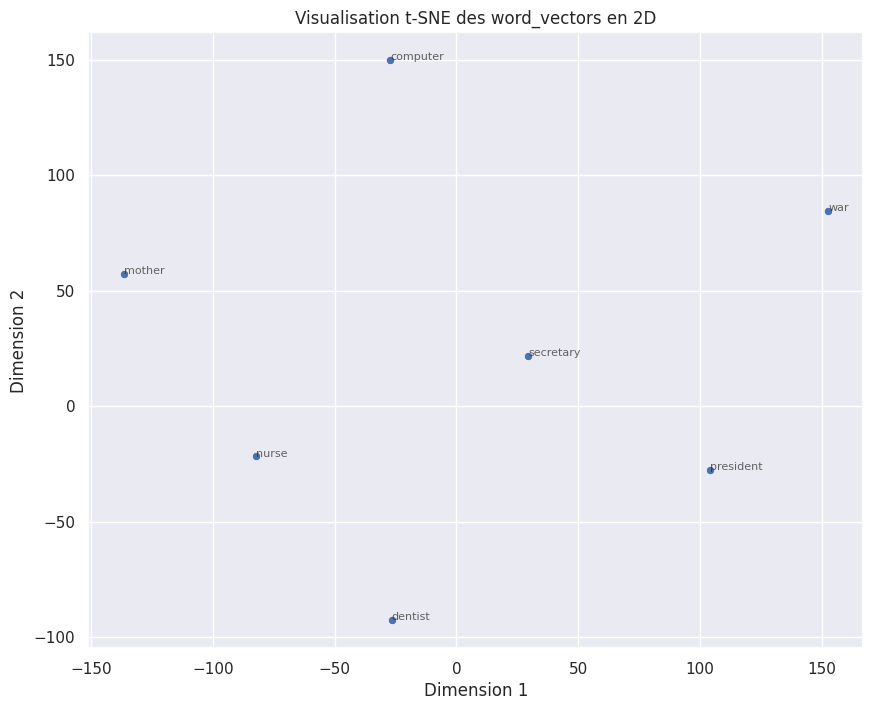

In [60]:
from sklearn.manifold import TSNE
# graphics
import pandas as pd

import matplotlib.pyplot as plt
# display matplotlib graphics in notebook
%matplotlib inline
import seaborn as sns
# Liste des mots de words_plus_neighbors
mots_words_plus_neighbors = [item[0] for item in words_plus_neighbors]

# Indices des mots de words_plus_neighbors dans la liste complète de mots
indices_mots = [mots.index(mot) for mot in mots_words_plus_neighbors]

# Extraire les embeddings correspondants aux mots de words_plus_neighbors
word_vectors = embeddings[indices_mots]

# Afficher le tableau de vecteurs
print(word_vectors)

tSNE = TSNE(random_state=0, n_iter=2000, perplexity=5.0)

T = tSNE.fit_transform(word_vectors)

df = pd.DataFrame(T, columns=['Dimension 1', 'Dimension 2'])

# Visualisation avec seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', data=df)

# Ajouter les labels des mots avec plt.annotate
for i, mot in enumerate(mots_words_plus_neighbors):
    plt.annotate(mot, (T[i, 0], T[i, 1]), fontsize=8, alpha=0.7)

plt.title('Visualisation t-SNE des word_vectors en 2D')
plt.show()


## 3. Evaluation des embeddings

### Évaluation intrinsèque

[A Survey of Word Embeddings Evaluation Methods](https://arxiv.org/pdf/1801.09536.pdf), Bakarov, 2018.


>les distances entre les mots dans un espace vectoriel pourraient être évaluées à l'aide des jugements heuristiques humains sur les distances sémantiques réelles entre ces mots (par exemple, la distance entre tasse et gobelet définies dans un intervalle continu 0, 1 serait 0.8 puisque ces mots sont synonymes, mais pas vraiment la même chose).



### Téléchargement des datasets pré-établis et annotés manuellement

Nous allons utiliser 4 jeux de données  pour évaluer la qualité des embeddings : [MEN](http://clic.cimec.unitn.it/~elia.bruni/MEN.html), [WS353R](http://www.aclweb.org/anthology/N09-1003.pdf), [SimLex999](http://leviants.com/ira.leviant/MultilingualVSMdata.html) et [MTurk](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.8607&rep=rep1&type=pdf).


Ces jeux de données contiennent des paires de mots dont la proximité sémantique a été évaluée manuellement par des humains. Pour chaque dataset, dataset.X contient une liste de paires de mots et dataset.y contient le score de proximité pour chaque paire.

* MEN, 3 000 paires évaluées par relation sémantique avec une échelle discrète de 0 à 50
* SimLex-999, 999 paires évaluées avec un fort respect pour la similarité sémantique avec une échelle de 0 à 10
* MTurk-287, 287 paires évaluées par relation sémantique avec une échelle de 0 à 5
* WordSim-353, 353 paires évaluées par similarité sémantique (cependant, certains chercheurs trouvent les instructions pour les évaluateurs ambiguës en ce qui concerne la similarité et l'association) sur une échelle de 0 à 10

In [68]:
# custom functions

similarity_tasks = {
    "MEN": similarity.fetch_MEN(),
    "WS353R": similarity.fetch_WS353(which="relatedness"),
    "SimLex999": similarity.fetch_SimLex999(),
    "MTurk": similarity.fetch_MTurk(),
}

for name, dataset in similarity_tasks.items():
    print('\n', name, ':',len(dataset.X),'items')
    for data, score in zip(dataset.X[:4], dataset.y[:4]):
        print(' '*4, ', '.join(data), ':', score)

NameError: name 'similarity' is not defined

In [62]:
! pip install similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.5 MB/s eta 0:00:00


### Résultats évaluation intrinsèque

Notre objectif est de comparer les similarités entre les paires de mots des datasets calculées à partir des embeddings et celles données par les annotateurs humains. Si un embedding prédit les similarités de la même manière que les humains, on estime qu'il est bon. On peut donc calculer la corrélation entre la proximité donné par l'embedding et celle donnée par les humains pour chaque paire de mots du dataset.

Pour cet excercice, nous allons utiliser  le classe [Embeddings](https://polyglot.readthedocs.io/en/latest/polyglot.mapping.html#module-polyglot.mapping.embeddings) de polyglot. Pour charger un embeddind avec cette classe :

`glove_embeddings =  Embedding.from_glove('data/glove.6B.50d.txt')`

Pour pouvoir charger les embeddings de Collobert de la même manière, il faut mettre les mots et les vecteurs dans un seul fichier, par exemple avec la commande linux `paste`:

`paste -d ' ' collobert_words.lst collobert_embeddings.txt > collobert.txt`



#### Question

> * pour chaque embedding Collober et Glove, et chaque dataset (MEN, WS353R, SimLex999 et MTurk), calculer la similarité entre les proximités données par l'embedding et celles données par les humains. On utilisera la fonction `similarity.evaluate_similarity(word_embeddings, dataset.X, dataset.y)` qui renvoit le [coefficient de correlation de Spearman](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman).
> * stocker les scores  pour chaque embedding et chaque dataset dans une liste `similarity_results = []` sous forme d'un dictonnaire : `similarity_results.append({'Embeddings': embeddings_name, 'Dataset': name, 'Score': score})`


In [65]:
# embedding functions
from polyglot.mapping import Embedding

similarity_results = []

# Load both embeddings with Embedding.from_glove from Polyglot
# YOUR CODE HERE

# Loop on embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:
    # loop on tasks
    for name, dataset in similarity_tasks.items():
        # compute similarity
        # YOUR CODE HERE



SyntaxError: incomplete input (<ipython-input-65-23ad8e6aa5f0>, line 15)

### Visualisation des résultats de similarité

Le code suivant permet de visualiser les coefficients de corrélation pour chaque dataset sur les différents jeux de test.

#### Question
> * Quel est selon ces métriques le meilleur embedding ?

In [ ]:
import pandas as pd


df = pd.DataFrame.from_dict(similarity_results, orient='columns')
df

fig = plt.figure()
fig.patch.set_facecolor('#f9f9f9')



sns.set(rc={'figure.figsize':(8, 6)})
sns.set(font_scale=1)

colors = ["#e74c3c", "#75d9fc", "#b4e0ef", "#34495e", "#e74c3c", "#2ecc71"]
ax = sns.barplot(x="Dataset", y="Score", hue="Embeddings", data=df, errwidth=0, palette=sns.color_palette(colors))


ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=False)
ax.set(xlabel="", ylabel="")

plt.show()

## Évaluation d'analogies

Notre objectif est maintenant d'explorer les relations sémantiques induites par l'arithmétique sur les embeddings. Nous allons donc explorer les analogies induites par les embeddings sous forme de raisonnement du type : "l'homme est au roi ce que la femme est à ?", la réponse étant "la reine". On peut calculer la réponse avec les représentations fournies par l'embedding par :  

`v = vecteur(roi)-vecteur(homme)+vecteur(femme)`.

La réponse étant alors le mot dont la représentation est la plus proche du vecteur `v`. Pour trouver le mot dont le vecteur est le plus proche de `v`, il faut définir une distance dans l'espace des embeddings. Nous utiliserons la [similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus)

#### Question
>* Implémenter la similarity cosinus à l'aide des fonctions [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html#numpy.dot) et [np.linalg.norm](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)
>* Appliquer le calcul d'analogies sur les triplets proposés ou ceux de votre choix. Observez-vous [ce phénomène](https://arxiv.org/pdf/1607.06520.pdf) ?

In [ ]:
def my_cosine_similarity(a,b):
    # YOUR CODE HERE

def sorted_by_similarity(word_embeddings, base_vector):
    """Returns words sorted by cosine distance to a given vector, most similar first"""
    words_with_distance = [(my_cosine_similarity(base_vector, word_embeddings[w]), w)
                           for w in word_embeddings.vocabulary]

    return sorted(words_with_distance, key=lambda t: t[0], reverse=True)

def is_redundant(word):
    return (
        word_1.lower() in word.lower() or
        word_2.lower() in word.lower() or
        word_3.lower() in word.lower())


pairs = [(['man', 'woman'], 'king'),
         (['man', 'programmer'], 'woman'),
         (['father', 'doctor'], 'mother'),
         (['father', 'facebook'], 'mother')
        ]

words_and_responses = []

# Note : you may need to update the following line with your Polyglot Embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:
    for pair in pairs:
        word_1, word_2, word_3 = pair[0][0], pair[0][1], pair[1]

        closest = sorted_by_similarity(embeddings,
                                       embeddings[word_2] - embeddings[word_1] +
                                       embeddings[word_3])[:10]

        closest = [(dist, w) for (dist, w) in closest if not is_redundant(w)] #

        print("{} + {} - {} = ? {}".format(word_2, word_3, word_1, closest[0][1]))
        words_and_responses += [word_1, word_2, word_3,closest[0][1]]

### Visualisation des analogies

Les relations d'analogies peuvent se visualiser dans l'espace des embeddings après réduction de dimension, par exemple avec tSNE.

In [ ]:
# Note : you may need to update the following line with your Polyglot Embeddings
for embeddings_name, embeddings in [('collobert', collobert_embeddings), ('glove', glove_embeddings)]:

    word_vectors = np.array([embeddings[word] for word in words_and_responses[:4]])

    tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=3.0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)

    fig = plt.figure()
    fig.patch.set_facecolor('#f9f9f9')

    sns.set(rc={'figure.figsize':(6, 6)})
    sns.set(font_scale=1.3)

    sns.scatterplot(x=T[:, 0], y=T[:, 1])

    for label, x, y in zip(words_and_responses, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Evaluation des embeddings de BERT

BERT a été un des premiers modèles de langue Transformer, entraînés sur de gros corpus, disponible librement. De nombreux modèles sont disponibles sur HuggingFace.

Comme BERT est un modèle contextuel, il est nécessaire de lui faire prédire des phrases entières pour étudier les embeddings de mots qu'il produit. Dans cette section, nous allons comparer les embeddings obtenus pour des mots polysémiques en fonction de la phrase dans laquelle ils sont utilisés.

En anglais, *plant* possède deux sens : celui d'usine et celui d'un végétal. Avec un embedding non contextuel, de type Glove ou Colobert, ces deux sens du mot plus sont associés à un identique embedding. Avec BERT, nous allons voir que le même mot peut avoir plusieurs embeddings en fonction du contexte.

First, load the BERT model and tokenizer from HuggingFace :

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # to access the hidden states
                                  )
# set the model to "evaluation" mode
model.eval()

### Tokenizer

Les modèles de langues sont entrainés avec un découpe spécifique des phrases en token. Ces tokens peuvent être des mots ou des parties de mots. Il est nécessaire d'utiliser le tokenizer correspondant à chaque model.

tokenizer.vocab.keys() donne la liste de tous les tokens connus du modèle de langue.

#### Question
>* combien de token différents sont connu du tokenizer de BERT ?
>* affichez une centaine de token aléatoirement. Que constatez-vous ?

In [ ]:
import random
# number of token in tokenizer
# YOU CODE HERE
# sample of 100 tokens
# YOU CODE HERE


Le tokenizer découpe les phrases et transforme les éléments (mots ou sous-mots) en indice.

BERT peut traiter plusieurs phrases mais il faut lui indiquer le découpage en phrases (segment) avec un indice : 0 pour la première phrases, 1 pour la deuxième.

Deux tokens spécifiques doivent être aussi ajoutés :
* [CLS], un token spécifique utilisé pour la classification de phrase
* [SEP], le token de fin de phrase.

#### Question
>* Appliquer la fonction bert_tokenize sur les 3 phases et conservez les 3 vecteurs (index, token, segment)
>* Affichez ces informations pour chacune des phrases et vérifier que le mot *plant* a bien le même indice de token dans les deux phrases où il apparait.

In [ ]:
snt1 = "The plant has reached its maximal level of production."
snt2 = "The cars are assembled inside the factory."
snt3 = "A plant needs sunlight and water to grow well."


def bert_tokenize(snt):
    """ Apply the BERT tokenizer to a list of words representing a sentence
        and return 3 lists:
        - list of token indx
        - list of token for debugging, not used by the BERT model
        - list of sentence index
        """
    # Add the special tokens.
    tagged_snt = "[CLS] " + snt + " [SEP]"
    # Tokenize
    tokenized_snt = tokenizer.tokenize(tagged_snt)
    # convert tokens to indices
    indexed_snt = tokenizer.convert_tokens_to_ids(tokenized_snt)
    # mark the words in sentence.
    segments_ids = [1] * len(tokenized_snt)

    return (indexed_snt, tokenized_snt, segments_ids)

# YOUR CODE HERE



## Inférence

Pour calculer les embeddings, il est nécessaire de faire une prédiction avec le modèle BERT sur une phrase complète. La fonction *predict_hidden* convertit les listes d'indices de token et de segment en tenseur pytorch et applique le modèle.

Le modème utilisé est un modèle à 12 couches. Nous allons utiliser la dernière couche caché du modèle comme embedding pour représenter les mots. D'autres solutions serait possible, comme une concaténation ou une moyene de plusieurs couches.


#### Question
>* Appliquer le modèle à chacune des 3 phrases et stocker les embeddings obtenus (tenseurs)
>* Afficher la dimension des tenseurs obtenus. Quelle est la dimension du vecteur d'embedding pour chaque mot ?


In [ ]:

def predict_hidden(indexed_snt, segments_ids):
    """Apply the BERT model to the input token indices and segment indices
        and return the last hidden layer
    """
    with torch.no_grad():
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_snt])
        segments_tensors = torch.tensor([segments_ids])
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
        one_hidden_layer = hidden_states[12][0]

    return one_hidden_layer

# YOUR CODE HERE



La couche cachée renvoyée par la fonction *predict_hidden* est un tenseur contenant pour chaque token de la phrase d'entrée un vecteur contextuel le représentant. On peut utiliser ce vecteur pour représenter le sens de ce mot en fonction de son contexte. Nous allons comparer la représentation du mot polysémique *plant* en fonction de son contexte.

#### Question
>* En utilisant la [distance cosinus](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html), calculer les distances suivantes:
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *plant* dans la phrase 3 (plant-vegetal)
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *factory* dans la phrase 2
>   * distance entre *plant* dans la phrase 1 (plant-factory) et *production* dans la phrase 2
>   * distance entre *plant* dans la phrase 3 (plant-vegetal) et *production* dans la phrase 2
> * Comment interprêter ces distances ?

In [ ]:
from scipy.spatial.distance import cosine

# YOUR CODE HERE
